In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [3]:
#keras 사전훈련모델 불러오기 
feature_model = keras.applications.DenseNet201(input_shape=(380,240,3), weights="imagenet", include_top=False)
feature_model.trainable= False

In [47]:
feature_model.save('feature_model.h5')

In [5]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

img_size = (320,240)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

train_generator = train_datagen.flow_from_directory(directory ='/content/drive/MyDrive/new_audio/train',
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 0,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = img_size)

valid_generator = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/new_audio/train',
                                                    subset = 'validation',
                                                    batch_size = batch_size,
                                                    seed = 0,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = img_size)

Found 1807 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'neg_mel': 0, 'pos_mel': 1}

In [7]:
batch_step = train_generator.n // batch_size
train_features = [] 
train_Y = [] 

for idx in tqdm(range(batch_step)):
  x, y = train_generator.next()
  train_Y.extend(y) 

  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)
print(train_Y)

  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [02:29<00:00,  2.66s/it]


(1792, 10, 7, 1920)
(1792, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [8]:
valid_features = [] 
valid_Y = [] 

batch_step = valid_generator.n // batch_size

for idx in tqdm(range(batch_step)):
    
    x, y = valid_generator.next()
    valid_Y.extend(y)
  
    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

100%|██████████| 14/14 [00:17<00:00,  1.27s/it]

(448, 10, 7, 1920)
(448, 2)


In [28]:
def build_model(feature_model):
    
    inputs = Input(shape=feature_model.output.shape[1:])
    
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs,
                 outputs = outputs)
    
    init_lr = 1e-3
    opt = Adam(lr=init_lr)
    model.compile(optimizer=opt, 
                  loss= 'categorical_crossentropy',
                  metrics='accuracy')
    
    
    return model

In [43]:
model = build_model(feature_model)

model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 11, 7, 1920)]     0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               245888    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 253,826
Trainable params: 249,986
Non-trainable params: 3,840
___________________________________________

In [44]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/My Drive/new_2.h5'

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   min_lr=1e-5)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 200,
                    batch_size = 32,
                    callbacks=callbacks_list)
model.summary()

Epoch 1/200
54/56 [===========================>..] - ETA: 0s - loss: 0.7857 - accuracy: 0.6291WARNING:tensorflow:Model was constructed with shape (None, 11, 7, 1920) for input Tensor("input_10:0", shape=(None, 11, 7, 1920), dtype=float32), but it was called on an input with incompatible shape (32, 10, 7, 1920).

Epoch 00001: val_accuracy improved from -inf to 0.75446, saving model to /content/drive/My Drive/new_2.h5
56/56 [==============================] - 1s 15ms/step - loss: 0.7813 - accuracy: 0.6317 - val_loss: 0.5727 - val_accuracy: 0.7545
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.7835
Epoch 00002: val_accuracy did not improve from 0.75446
56/56 [==============================] - 0s 6ms/step - loss: 0.4774 - accuracy: 0.7835 - val_loss: 0.5399 - val_accuracy: 0.7321
Epoch 3/200
55/56 [============================>.] - ETA: 0s - loss: 0.3624 - accuracy: 0.8420
Epoch 00003: val_accuracy did not improve from 0.75446
56/56 [==============

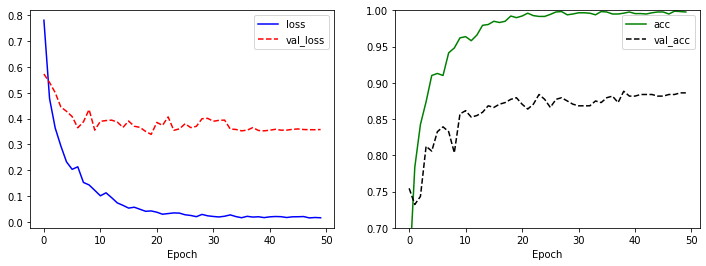

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.ylim([0.7, 1])
plt.legend()

plt.savefig('audio_train_plot.jpg')

In [46]:
model2 = load_model(checkpoint_path)

results = model2.evaluate(valid_features, valid_Y)
print('Test accuracy: ', results[1])

14/14 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.8884
Test accuracy:  0.8883928656578064
